
# 🚖 NYC Taxi Trip Location Network Analysis

This notebook analyzes the `trip_location_network_metrics` table, generated from dbt models. It explores trends in trip counts, durations, and distances between location pairs, and reveals insights about boroughs and zones in New York City.


In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Optional: Set pandas and seaborn display options
pd.set_option('display.max_columns', 100)
sns.set(style='whitegrid')

In [2]:
from clickhouse_connect import get_client

# ClickHouse Configuration
CLICKHOUSE_CONFIG = {
    "host": "localhost",
    "port": 8123,
    "username": "ziadashraf98765", 
    "password": "x5x6x7x8",
    "database": "data_warehouse"
}

client = get_client(**CLICKHOUSE_CONFIG)


query = f"""
                SELECT 
                    *
                FROM trip_location_network_metrics
"""

data = client.query_df(query)
data


,source_location,target_location,trip_count,avg_distance,sum_total_amounts,avg_duration_minutes
0,Cambria Heights,Melrose South,14,19.43,809.15,41.35
1,Willets Point,Rockaway Park,4,17.65,296.21,38.05
2,Midtown South,Central Park,65014,3.55,1324666.83,19.78
3,Queens Village,East Flatbush/Farragut,108,14.58,5735.61,46.74
4,Middle Village,Spuyten Duyvil/Kingsbridge,4,13.00,185.22,50.19
...,...,...,...,...,...,...
61777,Ozone Park,Clinton West,10,12.71,626.75,50.96
61778,North Corona,Belmont,19,11.61,926.31,33.10
61779,Saint George/New Brighton,South Jamaica,2,29.11,201.51,61.92
61780,Little Italy/NoLiTa,Brighton Beach,149,14.99,8841.22,36.54


In [3]:
# df is your DataFrame from SQL
G = nx.from_pandas_edgelist(
    data,
    source="source_location",
    target="target_location",
    edge_attr=["trip_count", "avg_distance", "sum_total_amounts", "avg_duration_minutes"],
    create_using=nx.DiGraph()  # directed graph
)

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

# Edge attributes example
for u, v, data_ in G.edges(data=True):
    print(u, "->", v, data_)
    break

Nodes: 262
Edges: 61782
Cambria Heights -> Melrose South {'trip_count': 14, 'avg_distance': 19.43, 'sum_total_amounts': 809.15, 'avg_duration_minutes': 41.35}


In [20]:
from pyvis.network import Network

# Create network with inline resources
net = Network(notebook=True, directed=True, cdn_resources="in_line")
net.from_nx(G)
net.force_atlas_2based()

# Show directly in Jupyter
net.show("network.html")

network.html


In [4]:
# In-degree centrality (attracting trips)
in_centrality = nx.in_degree_centrality(G)

# Out-degree centrality (sending trips)
out_centrality = nx.out_degree_centrality(G)

# Combine into a DataFrame for easier comparison
import pandas as pd

centrality_df = pd.DataFrame({
    "in_degree": in_centrality,
    "out_degree": out_centrality
})

# Add asymmetry: inbound - outbound
centrality_df["asymmetry"] = centrality_df["in_degree"] - centrality_df["out_degree"]

# Sort by inbound hubs
top_inbound = centrality_df.sort_values("in_degree", ascending=False).head(10)
print("Top 10 inbound hubs (trip attractors):")
print(top_inbound)

# Sort by outbound hubs
top_outbound = centrality_df.sort_values("out_degree", ascending=False).head(10)
print("\nTop 10 outbound hubs (trip generators):")
print(top_outbound)

# Sort by asymmetry
top_asymmetry = centrality_df.sort_values("asymmetry", ascending=False).head(10)
print("\nTop 10 net attractors (more inbound than outbound):")
print(top_asymmetry)


Top 10 inbound hubs (trip attractors):
                           in_degree  out_degree  asymmetry
JFK Airport                 0.996169    1.000000  -0.003831
Kips Bay                    0.992337    0.996169  -0.003831
NA                          0.992337    0.992337   0.000000
TriBeCa/Civic Center        0.992337    0.996169  -0.003831
Times Sq/Theatre District   0.992337    1.000000  -0.007663
Lenox Hill East             0.988506    0.996169  -0.007663
East Harlem South           0.988506    0.996169  -0.007663
East Village                0.988506    0.996169  -0.007663
Greenwich Village North     0.988506    0.996169  -0.007663
East Harlem North           0.988506    0.984674   0.003831

Top 10 outbound hubs (trip generators):
                               in_degree  out_degree  asymmetry
Times Sq/Theatre District       0.992337    1.000000  -0.007663
JFK Airport                     0.996169    1.000000  -0.003831
Murray Hill                     0.984674    1.000000  -0.015326
York

### 🚖 Inbound Hubs (Trip Attractors)

* **JFK Airport, Times Sq, TriBeCa, Kips Bay** dominate as **top inbound hubs**.
* These are **key demand destinations**: airports, tourism zones, and business districts.
* **Impact**: allocate more **driver supply** near these hubs to reduce passenger wait time and capture surge demand.

---

### 🚕 Outbound Hubs (Trip Generators)

* **Murray Hill, Midtown South, Sutton Place, Central Park** appear high on **out-degree**.
* These are **residential & commuter-heavy areas** → strong morning/evening outbound demand.
* **Impact**: anticipate **rush-hour spikes**, optimize **driver repositioning** towards central destinations.

---

### 🛬 Net Attractors (Inbound > Outbound)

* **Newark Airport, Staten Island neighborhoods (Eltingville, Great Kills, Oakwood, Charleston, etc.)** stand out.
* They **attract trips but generate few** → mostly **one-way demand** into these zones.
* **Impact**: risk of **driver imbalance** — vehicles may end up stranded. Solutions:

  * Dynamic pricing or incentives for **return trips**.
  * Partner services (e.g., airport shuttles, local contracts) to balance flow.

---

✅ **Strategic takeaway**:

* Airports & tourism zones → **driver allocation priority**.
* Residential zones → **forecast commuting peaks**.
* Net attractors (like Newark) → **incentive schemes** to avoid deadhead miles.

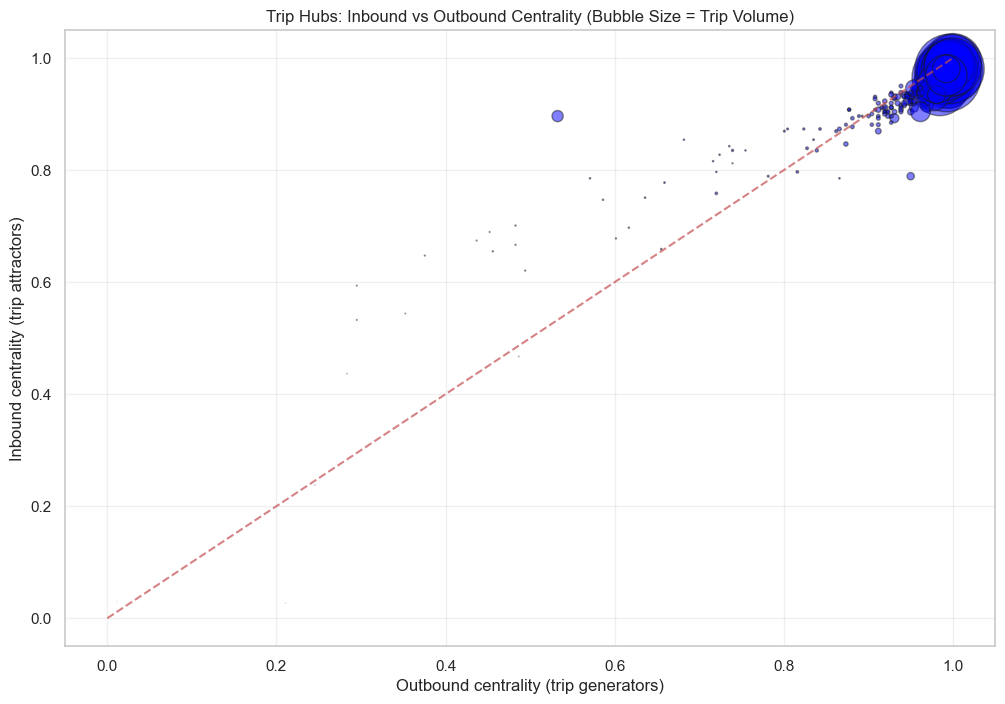

In [6]:
import matplotlib.pyplot as plt

# Compute weighted trip volume per node (sum of inbound + outbound trip_count)
trip_volume = {}
for u, v, data_ in G.edges(data=True):
    trip_volume[u] = trip_volume.get(u, 0) + data_["trip_count"]
    trip_volume[v] = trip_volume.get(v, 0) + data_["trip_count"]

centrality_df["trip_volume"] = centrality_df.index.map(trip_volume.get)

# Scatter plot with bubble size = trip volume
plt.figure(figsize=(12, 8))
plt.scatter(
    centrality_df["out_degree"],
    centrality_df["in_degree"],
    s=centrality_df["trip_volume"]/10000,  # scale down bubble size
    alpha=0.5,
    c="blue",
    edgecolors="k"
)

# Diagonal reference line
plt.plot([0, 1], [0, 1], "r--", alpha=0.7)

plt.title("Trip Hubs: Inbound vs Outbound Centrality (Bubble Size = Trip Volume)")
plt.xlabel("Outbound centrality (trip generators)")
plt.ylabel("Inbound centrality (trip attractors)")
plt.grid(True, alpha=0.3)
plt.show()


In [9]:
import matplotlib.pyplot as plt
import networkx as nx

# compute positions (faster than spring_layout for 500+ nodes)
pos = nx.kamada_kawai_layout(G)

# edge weights (for scaling width)
weights = [d["trip_count"] for (_, _, d) in G.edges(data=True)]

plt.figure(figsize=(10, 8))

# simple draw in one call (no arrows, small nodes)
nx.draw(
    G, pos,
    node_size=50,
    node_color="skyblue",
    edge_color="gray",
    width=[w / max(weights) * 2 for w in weights],  # lighter scaling
    with_labels=False
)

plt.title("Trip Location Network (simplified view)", fontsize=14)
plt.axis("off")
plt.show()


KeyboardInterrupt: 

<Figure size 1000x800 with 0 Axes>

## 📊 Dataset Overview

In [4]:

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (252097, 15)


,trip_year_month,source_location,pickup_borough,pickup_zone,pickup_service_zone,target_location,dropoff_borough,dropoff_zone,dropoff_service_zone,trip_count,avg_distance,total_fare,total_tip,avg_total,avg_duration_minutes
0,2019-01,1,EWR,Newark Airport,EWR,95,Queens,Forest Hills,Green Zone,1,22.85,79.50,9.08,99.88,109.98
1,2019-01,1,EWR,Newark Airport,EWR,164,Manhattan,Midtown South,Yellow Zone,1,15.40,61.00,7.70,80.00,34.00
2,2019-01,3,Bronx,Allerton/Pelham Gardens,Green Zone,2,Queens,Jamaica Bay,Green Zone,1,23.29,61.77,0.00,70.19,39.33
3,2019-01,3,Bronx,Allerton/Pelham Gardens,Green Zone,3,Bronx,Allerton/Pelham Gardens,Green Zone,21,1.33,268.72,2.97,13.76,12.24
4,2019-01,3,Bronx,Allerton/Pelham Gardens,Green Zone,6,Staten Island,Arrochar/Fort Wadsworth,Green Zone,1,51.79,81.94,0.00,93.96,97.43


In [5]:

print("Missing values:")
df.isnull().sum()


Missing values:


trip_year_month         0
source_location         0
pickup_borough          0
pickup_zone             0
pickup_service_zone     0
target_location         0
dropoff_borough         0
dropoff_zone            0
dropoff_service_zone    0
trip_count              0
avg_distance            0
total_fare              0
total_tip               0
avg_total               0
avg_duration_minutes    0
dtype: int64

In [6]:
df.describe()

,source_location,target_location,trip_count,avg_distance,total_fare,total_tip,avg_total,avg_duration_minutes
count,252097.000000,252097.000000,252097.000000,252097.000000,252097.000000,252097.000000,252097.000000,252097.000000
mean,127.539764,135.962546,24.151037,9.140887,319.022889,26.714757,34.970058,40.494690
std,76.224266,76.165980,150.308694,26.515498,1158.647037,132.756333,19.987789,78.229355
min,1.000000,1.000000,1.000000,0.010000,0.010000,0.000000,0.010000,1.020000
25%,62.000000,71.000000,1.000000,4.290000,42.500000,0.000000,19.890000,20.130000
50%,123.000000,137.000000,3.000000,7.640000,84.000000,0.000000,31.170000,29.770000
75%,193.000000,203.000000,9.000000,12.610000,221.740000,10.160000,46.230000,43.620000
max,265.000000,265.000000,7476.000000,12467.880000,43370.350000,5181.990000,1080.800000,2122.830000


## 📈 Trip Trends Over Time

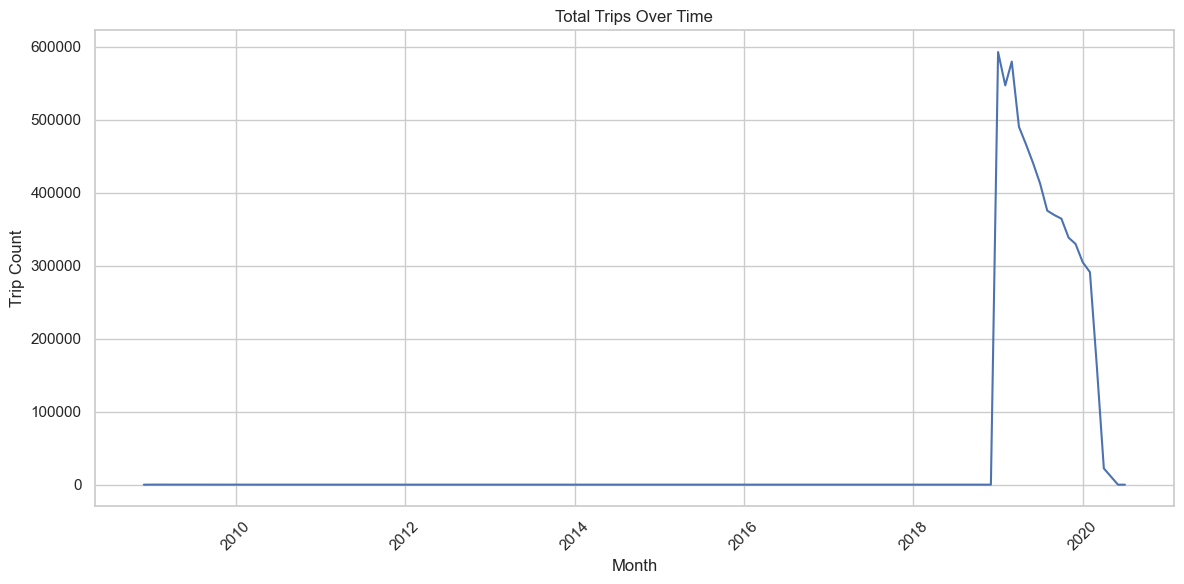

In [7]:

df['trip_year_month'] = pd.to_datetime(df['trip_year_month'])
monthly = df.groupby('trip_year_month')['trip_count'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly, x='trip_year_month', y='trip_count')
plt.title('Total Trips Over Time')
plt.ylabel('Trip Count')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 🚕 Top Source → Target Routes

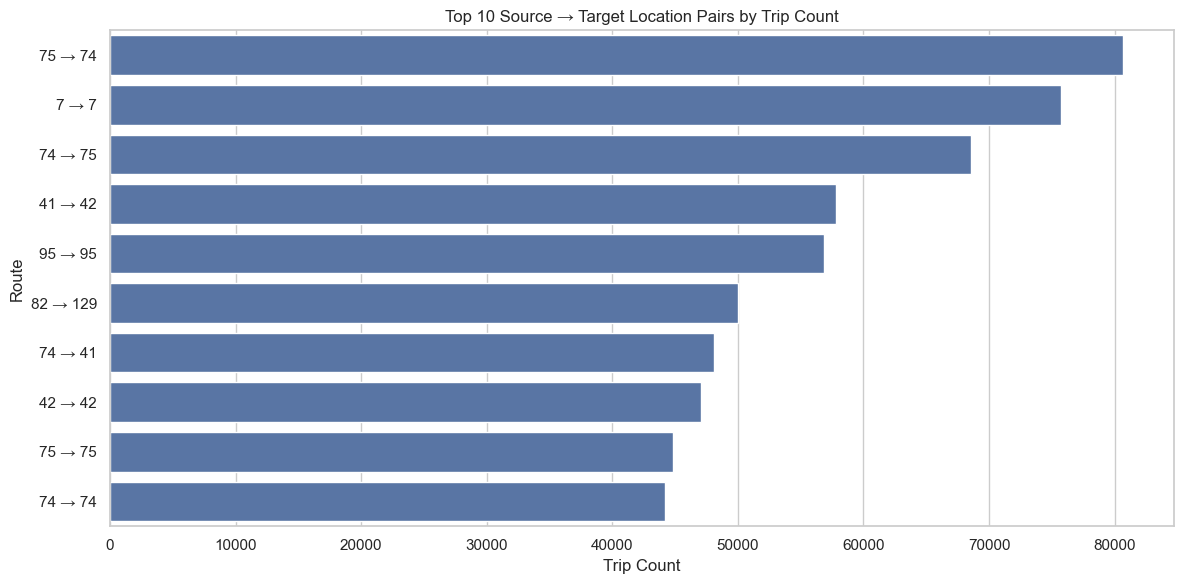

In [9]:

top_pairs = df.groupby(['source_location', 'target_location'])['trip_count'].sum().reset_index().sort_values(by='trip_count', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_pairs, x='trip_count', y=top_pairs.apply(lambda row: f"{row.source_location} → {row.target_location}", axis=1))
plt.title('Top 10 Source → Target Location Pairs by Trip Count')
plt.xlabel('Trip Count')
plt.ylabel('Route')
plt.tight_layout()
plt.show()


## ⏱️ Distance vs Duration

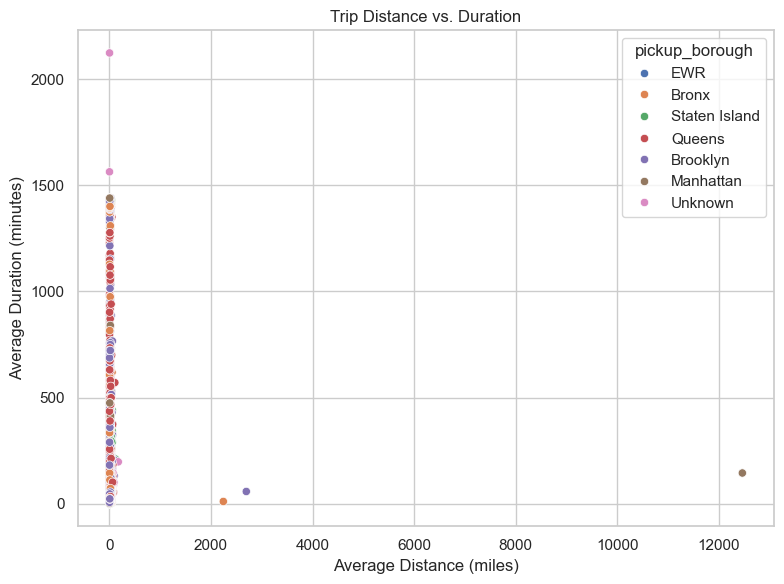

In [10]:

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='avg_distance', y='avg_duration_minutes', hue='pickup_borough')
plt.title('Trip Distance vs. Duration')
plt.xlabel('Average Distance (miles)')
plt.ylabel('Average Duration (minutes)')
plt.tight_layout()
plt.show()


## 🌆 Most Active Pickup Zones

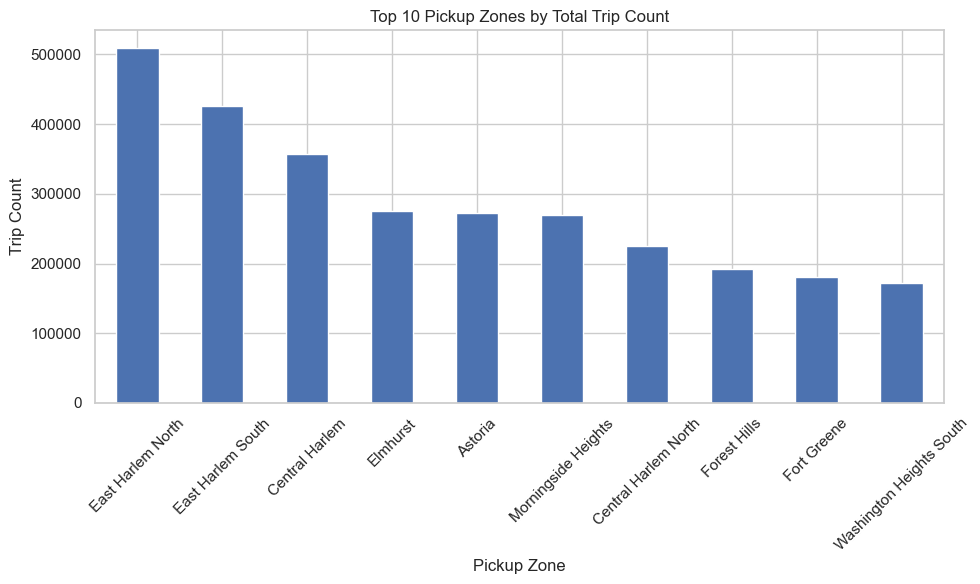

In [11]:

zone_avg = df.groupby('pickup_zone')['trip_count'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
zone_avg.plot(kind='bar')
plt.title('Top 10 Pickup Zones by Total Trip Count')
plt.ylabel('Trip Count')
plt.xlabel('Pickup Zone')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\MSI\AppData\Local\Temp\ipykernel_15232\3897201675.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


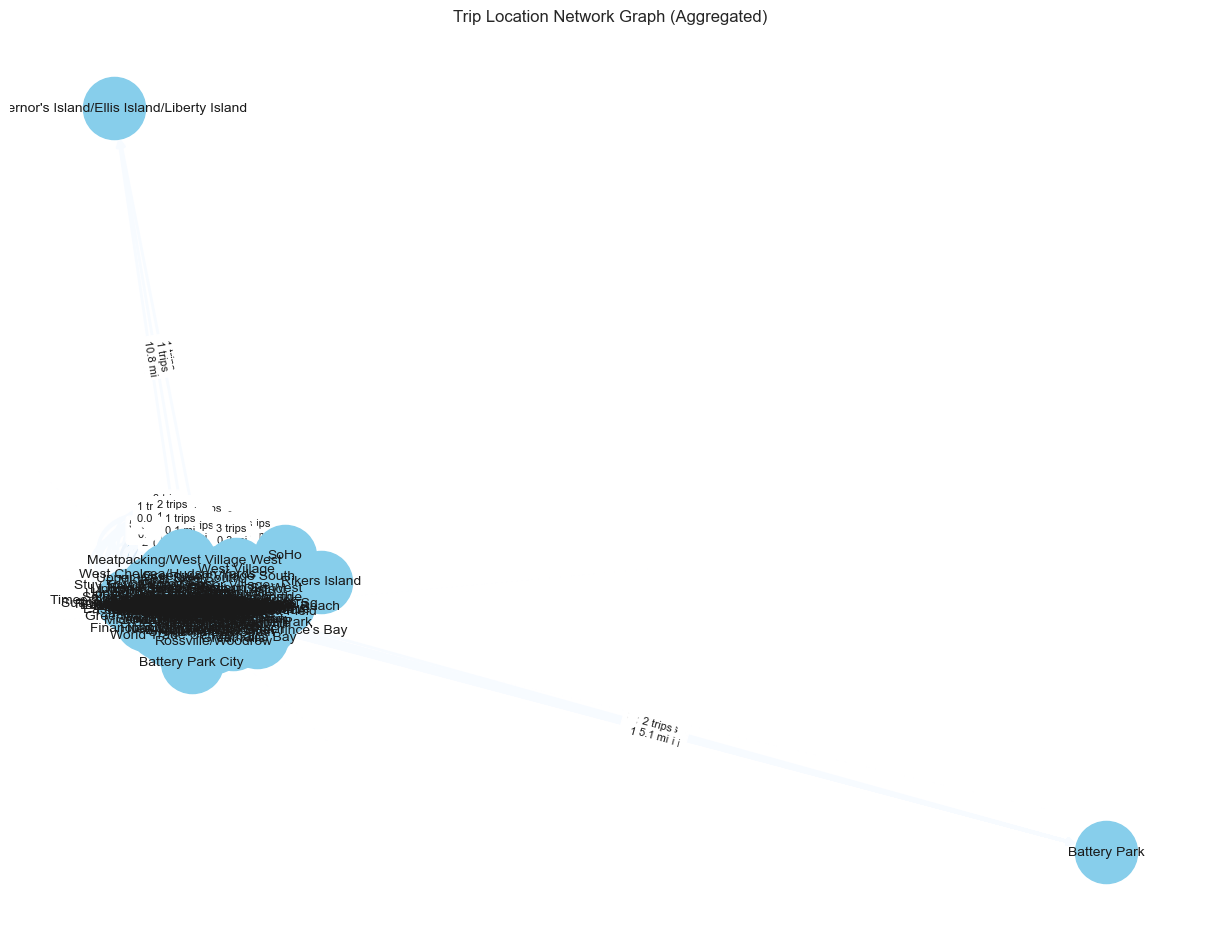

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Step 1: Group data by source and target locations
df_grouped = df.groupby(['pickup_zone', 'dropoff_zone'], as_index=False).agg({
    'trip_count': 'sum',
    'avg_distance': 'mean'
})


# Step 2: Create directed graph
G = nx.DiGraph()

# Add edges with weights
for _, row in df_grouped.iterrows():
    G.add_edge(
        row["pickup_zone"],
        row["dropoff_zone"],
        weight=row["trip_count"],
        label=f'{row["trip_count"]} trips\n{row["avg_distance"]:.1f} mi'
    )

# Step 3: Draw graph
plt.figure(figsize=(12, 9))
pos = nx.spring_layout(G, seed=42)

# Draw nodes and edges
weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000,
        edge_color=weights, width=2, edge_cmap=plt.cm.Blues, font_size=10)

# Add edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Trip Location Network Graph (Aggregated)")
plt.axis('off')
plt.tight_layout()
plt.show()
